# Lab 7 - Recurrent Neural Networks
## Nick Bias
### 5/23/22
## Goal: Predict Bitcoin Stock
### Libraries 

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

## Import Data

In [2]:
dataLink = "Data/Week8/dc.csv"

In [3]:
data = pd.read_csv("Data/Week8/dc.csv")
data

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,5/7/2018,36232.68941,9661.02,36340.13837,9689.67,34432.42240,9181.00,35122.49600,9365.00,33787
1,5/8/2018,35122.49600,9365.00,35537.66528,9475.70,33980.64922,9060.54,34457.02502,9187.56,25533
2,5/9/2018,34421.17120,9178.00,35216.25600,9390.00,33622.33600,8965.00,34916.22400,9310.00,25673
3,5/10/2018,34916.22400,9310.00,35235.45805,9395.12,33641.08800,8970.00,33761.85088,9002.20,25055
4,5/11/2018,33761.88838,9002.21,33816.60672,9016.80,31282.08640,8341.00,31503.36000,8400.00,48227
...,...,...,...,...,...,...,...,...,...,...
995,1/26/2021,120966.11420,32254.19,123470.21880,32921.88,115652.47240,30837.37,121767.12460,32467.77,84972
996,1/27/2021,121753.02310,32464.01,122102.86040,32557.29,109668.14670,29241.72,113885.20900,30366.15,95911
997,1/28/2021,113870.35740,30362.19,126703.43860,33783.98,111919.81180,29842.10,125131.57090,33364.86,92621
998,1/29/2021,125144.02230,33368.18,144510.03780,38531.90,119695.51620,31915.40,128459.45090,34252.20,231827


Since Recurennt Neural Networks only take 1 variable, I will be using 'close_USD', as this is the closest to the actual price of bitcoin, and the rest of the variables are highly correlated.

## Models 
## Simple Recurrent Neural Network, Train-Test-Split = 80%, Time Steps = 1

### Functions for Models 


In [4]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = pd.read_csv(url, usecols=[8], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))   

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

In [5]:
# used so it will not print all epochs
class Callback(tf.keras.callbacks.Callback):
    SHOW_NUMBER = 10
    counter = 0
    epoch = 0

In [6]:
train_data, test_data, data = get_train_test(dataLink)

time_steps = 1
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [7]:
model = create_RNN(hidden_units=100, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, callbacks=[Callback()], verbose=0)

In [8]:
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.008 RMSE
Test RMSE: 0.068 RMSE


The most simple Recurrent Neural Network produced the best results out of all the models attempted in this lab. Nothing was able to beat this amazing score. Its Train RMSE is less than 0.01 at 0.008, while its Test RMSE is 0.068. These RMSEs are very close to zero so it is safe to say this simple RNN model fits the data well. 

If we look below at tthe graph, we can see that the Actual and Prediction result lines are overlapping for almost the whole time, until the end. Starting around Time Steps 900, the Predictions start under predicting the actual Bitcoin Stock. 

Overall, this model is great, and better than the coming models. 

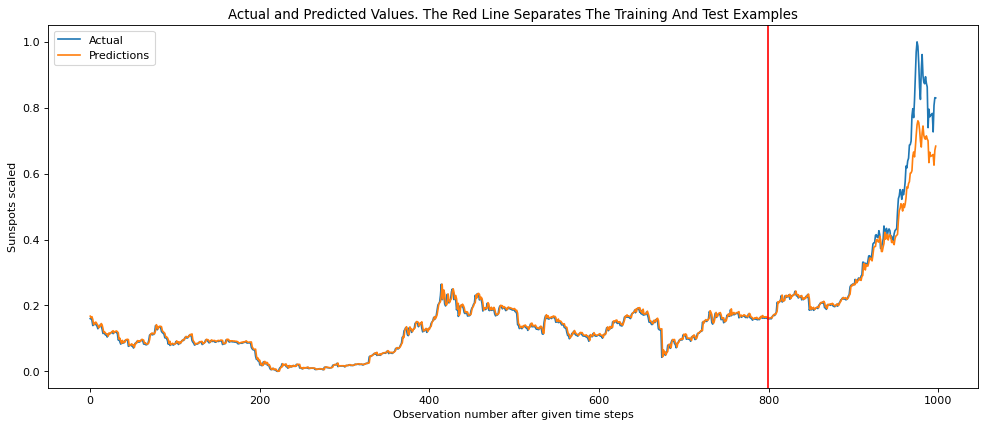

In [9]:
#Plot result
plt.rcParams["figure.figsize"] = (20,10)
plot_result(trainY, testY, train_predict, test_predict)

In [10]:
model = create_RNN(hidden_units=500, dense_units=1, input_shape=(time_steps,1), 
                   activation=['sigmoid', 'sigmoid'])
model.fit(trainX, trainY, epochs=20, batch_size=1, callbacks=[Callback()], verbose=0)

In [11]:
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.019 RMSE
Test RMSE: 0.136 RMSE


This RNN model used 500 hidden nodes and a sigmoid activation function. Overall, it performed slightly worse than the previous model. The Train RMSE is 0.019, which is more than double the original Train RMSE. The Test RMSE is 0.136, which is double the original Train RMSE. 

If we look below at the graph, we can see that the Prediction line does not quite overlap the Actual line. However, it is still very close. But once we get to 800 time steps, the predictions really start to deviate from the actual Bitcoin Stock.

Overall, the previous model fits the data better.

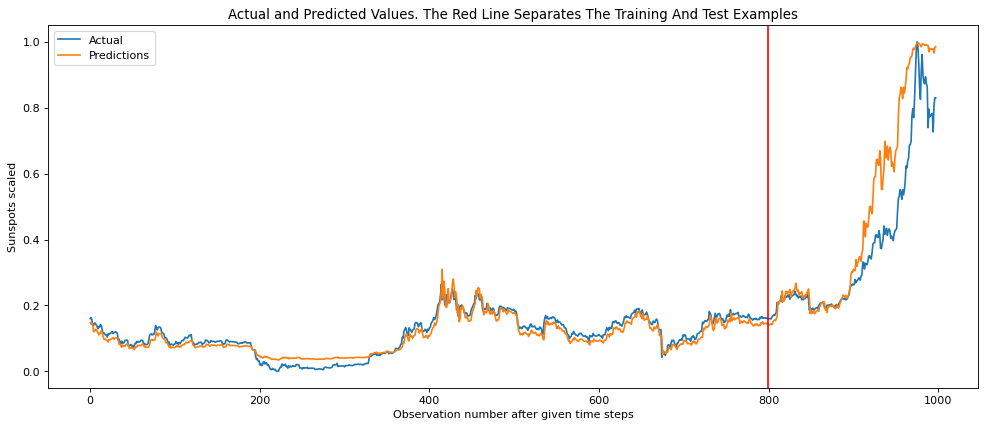

In [12]:
#Plot result
plt.rcParams["figure.figsize"] = (20,10)
plot_result(trainY, testY, train_predict, test_predict)

## LSTM Recurrent Neural Network, Train-Test-Split = 80%, Time Steps = 1

In [26]:
dataframe = pd.read_csv('Data/Week8/dc.csv', usecols=[8], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [27]:
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [28]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back), activation = 'tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, callbacks=[Callback()], verbose=0)

In [32]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY2 = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY2 = scaler.inverse_transform([testY])

In [33]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY2[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY2[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 404.38 RMSE
Test Score: 934.44 RMSE


The RMSEs for the LSTM Neural Network did not perform nearly as well as the Simple RNN models. The Train RMSE is 404.38, which is less than half the Test RMSE, which is 934.44. For reference, based on a general rule of thumb, it can be said that RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. This means the model is not predicting well.

However, if we look at the graph below, The Prediction and Actual Result lines are fairly close. It seems to be slightly over predicting the stock. It is not as close as the first RNN model, but still following the curves in the data very well. This may be due to the inverse scaling performed on the model to get compare the results. 

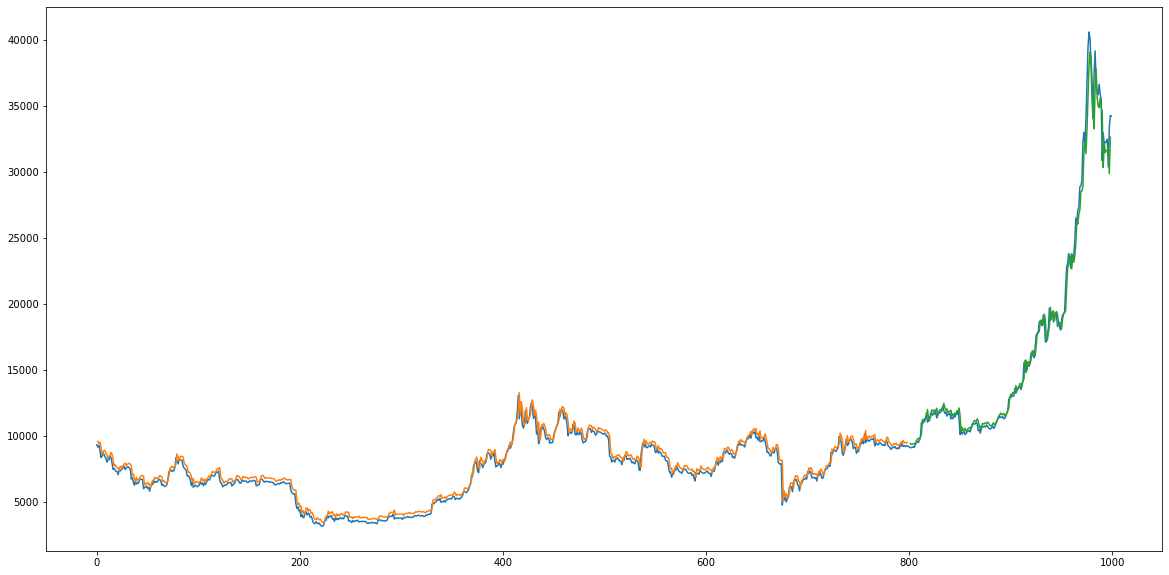

In [34]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [35]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(500, input_shape=(1, look_back), activation = 'sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, callbacks=[Callback()], verbose=0)

In [36]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY2 = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY2 = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY2[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY2[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 422.21 RMSE
Test Score: 984.38 RMSE


This model is again using a sigmoid activation function and 500 hidden nodes. Overall, it performed slightly worse than the Orginial LSTM model. These larger RMSEs indicate that the model is not predicting on the data well.

However, we can see the graph below, once again the model is still following the curves in the data very well. It also seems to under predict the Bitcoin Stock. The first Simple RNN is still the best model.

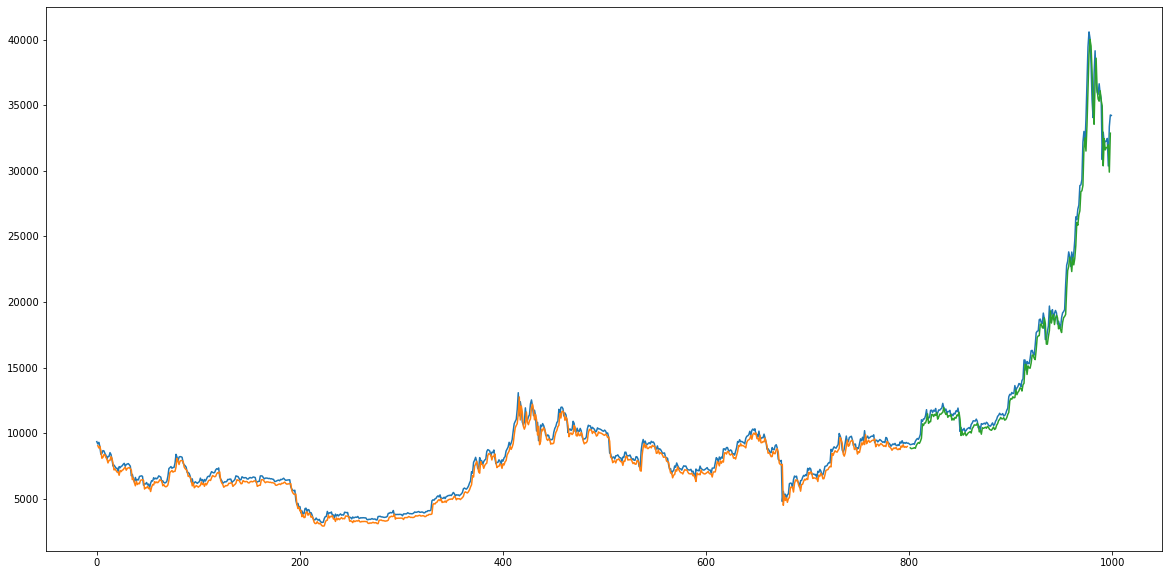

In [37]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## GRU Recurrent Neural Network, Train-Test-Split = 80%, Time Steps = 1

In [39]:
dataframe = pd.read_csv('Data/Week8/dc.csv', usecols=[8], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

time_steps= 1
input_shape=(time_steps,1)

In [40]:
model = keras.Sequential()
model.add(layers.GRU(100, input_shape=input_shape, activation = 'tanh'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=20, batch_size=1, callbacks=[Callback()], verbose=0)

In [41]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY2 = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY2 = scaler.inverse_transform([testY])

In [42]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY2[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY2[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2137.72 RMSE
Test Score: 12448.54 RMSE


The GRU models performed horribly compared to the previous 4 models. The Train RMSE is more than 5 times more than the previous LSTM model. The Test RMSE is more than 12.5 times more than the previous LSTM Model. This means that the model is not even predicting on the data at all.

If we look at the graph below, we can see that the Prediction results just stay around 7500. It never follows along the actual results. This means that this model is not a good fit for this data. 

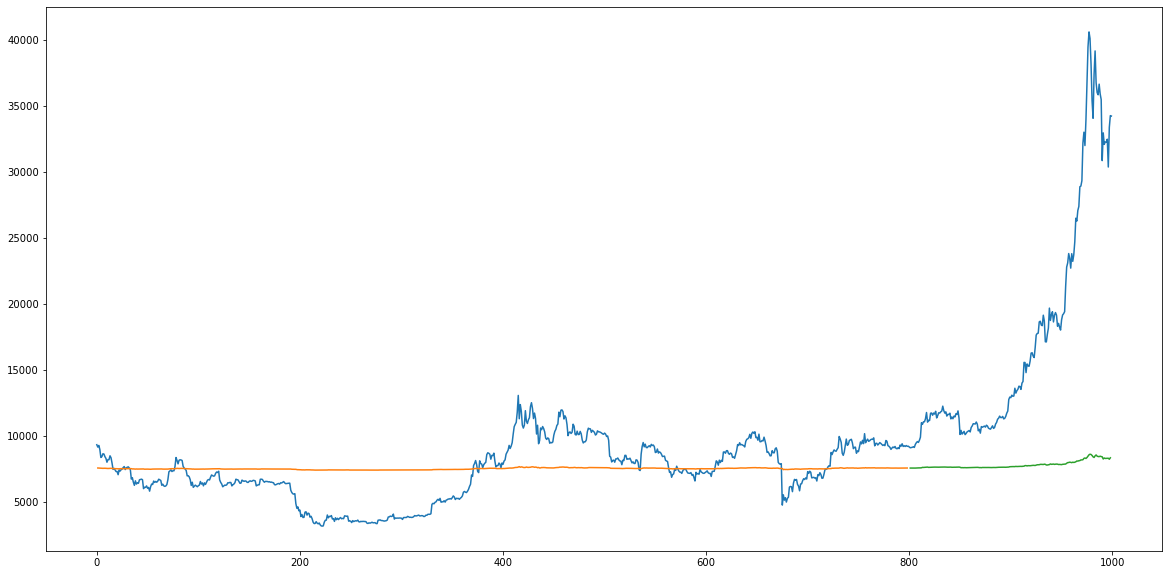

In [43]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [45]:
model = keras.Sequential()
model.add(layers.GRU(500, input_shape=input_shape, activation = 'sigmoid'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=20, batch_size=1, callbacks=[Callback()], verbose=0)

In [47]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY2 = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY2 = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY2[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY2[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2185.86 RMSE
Test Score: 13042.33 RMSE


The RMSEs for this final GRU model is not only the worst GRU model, but the worst Neural Network model attempted for this assignment. If we look at the graph below it is once again only predicting around 7500. This model is not predicting at all. It just keeps giving similar values without looking at the data. 

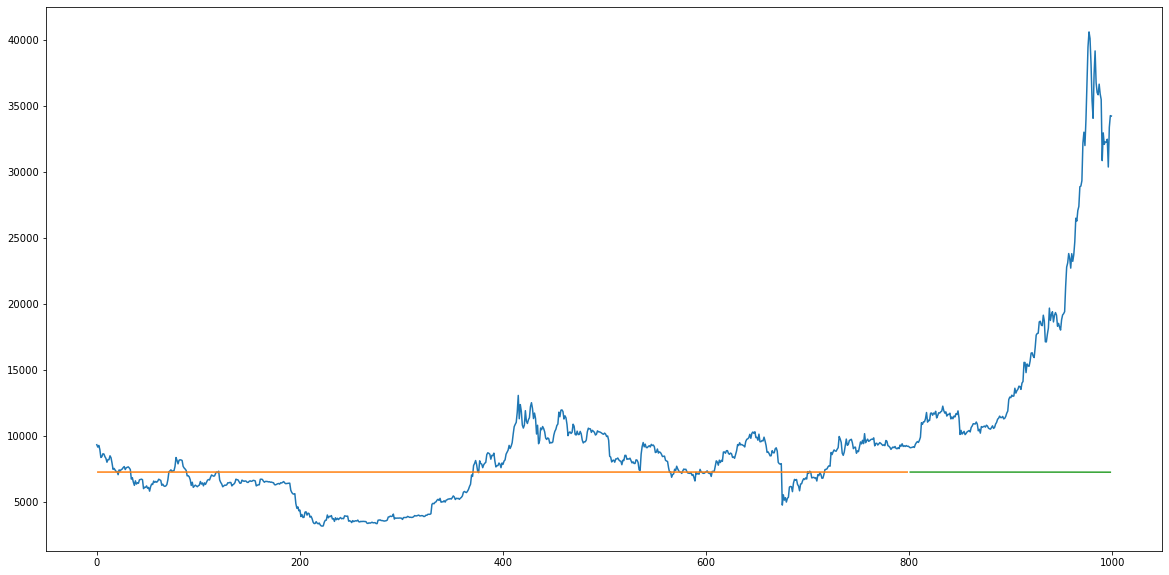

In [48]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Final Thoughts 
Overall, the best models for predicting Bitcoin Stock were the Simple Recurrent Neural Network Models. They produced the best RMSE scores that were very close to 0, which indicates that the model can relatively predict the data accurately. Through looking at the graphs, these models were very close with their predictions because the lines were almost overalapping. The LSTM models did not produce the best RMSE scores, but through looking their graphs, they were only slightly over predicting and under predicting the actual results. Finally the GRU models performed the worst. The had horrible RMSE scores in the thousands and looking at their graphs, it was clear to see they were not even predicting at all. 